In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt

import os
import operator

import networkx as nx

# Read the Food Reviews Data

In [2]:
file = 'foods.txt'
with open(file, 'r') as file:
    lines = file.readlines()

In [3]:
# Create a dictionary to store the data for the dataframe
data = {}

In [4]:
# Show the first two records
lines[:18]

['product/productId: B001E4KFG0\n',
 'review/userId: A3SGXH7AUHU8GW\n',
 'review/profileName: delmartian\n',
 'review/helpfulness: 1/1\n',
 'review/score: 5.0\n',
 'review/time: 1303862400\n',
 'review/summary: Good Quality Dog Food\n',
 'review/text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.\n',
 '\n',
 'product/productId: B00813GRG4\n',
 'review/userId: A1D87F6ZCVE5NK\n',
 'review/profileName: dll pa\n',
 'review/helpfulness: 0/0\n',
 'review/score: 1.0\n',
 'review/time: 1346976000\n',
 'review/summary: Not as Advertised\n',
 'review/text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".\n',
 '\n']

In [5]:
# For each line, separate the header from the data
# And add the data to the data dictionary
for line in lines:
    try:
        key, value = line.strip().split(': ', 1)
        try:
            if data[key]:
                data[key].append(value)
        except KeyError:
            data[key] = [value]
    except ValueError:
        continue

In [6]:
# Make a DataFrame with the parsed data
df = pd.DataFrame(data)

In [7]:
# Rename the columns
cols = ['ProductId', 'UserId', 'ProfileName', 'Helpfulness', 'Score', 'Time', 'Summary', 'Text']
df.columns = cols

In [8]:
# Show the resulting dataframe
df.head()

,ProductId,UserId,ProfileName,Helpfulness,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568454 non-null  object
 1   UserId       568454 non-null  object
 2   ProfileName  568454 non-null  object
 3   Helpfulness  568454 non-null  object
 4   Score        568454 non-null  object
 5   Time         568454 non-null  object
 6   Summary      568454 non-null  object
 7   Text         568454 non-null  object
dtypes: object(8)
memory usage: 34.7+ MB


In [10]:
# Convert the Score variable to type float
df['Score'] = df['Score'].astype(float)

# Group By UserId

In [11]:
gpby_user = df.groupby('UserId')['ProductId'].count()

In [12]:
by_user = pd.DataFrame(gpby_user)

In [13]:
by_user = by_user.sort_values('ProductId', ascending=False)

In [14]:
by_user

,ProductId
UserId,
A3OXHLG6DIBRW8,448
A1YUL9PCJR3JTY,421
AY12DBB0U420B,389
A281NPSIMI1C2R,365
A1Z54EM24Y40LL,256
...,...
A2HROKQO0GA5AF,1
A2HROR28DMJV2W,1
A2HRR8CO2Y20G8,1


# Network with Top 50 Food Reviewers

For this network, the food reviewers, or the users will be the nodes in the network. Edges between two nodes will exist if the two users wrote a review for the same product. 

The weight of the node will be the **number of reviews the two users wrote for the same product with the same score**. This allows us to find a weighted connection between users who have similar opinions on foods.

In [15]:
# Get the UserID of the top 10 reviewers
top_users = list(by_user.reset_index()['UserId'])[:50]

In [16]:
# Show the top 100 fine food reviewers
len(top_users)

50

# Find every pair combination for the top 50 reviewers

In [17]:
from itertools import product

In [18]:
user_a = top_users.copy()
user_b = top_users.copy()

In [19]:
unique_pairs = set()

for x,y in product(user_a, user_b):
    if x != y:
        unique_pairs.add(tuple(sorted((x,y))))

In [20]:
len(unique_pairs)

1225

In [21]:
# Find the number of same reviews for each pair in the top 50 reviewers
num_same = []

for pair in unique_pairs:
    
    # Get the dataframe of reviews for each user
    user_a = df[df['UserId'] == pair[0]]
    user_b = df[df['UserId'] == pair[1]]
    
    # Find the intersection of reviews based on ProductId and Score
    same = pd.merge(user_a, user_b, on=['ProductId', 'Score'], how='inner')
    
    num_same.append(len(same))

In [22]:
# Create a list of User_a and User b
UserA = []
UserB = []

for pair in unique_pairs:
    UserA.append(pair[0])
    UserB.append(pair[1])

In [23]:
# Create a dictionary to store the user data 
# Then store the data into a dataframe

data = {'User A': UserA, 'User B': UserB, 'Weight': num_same}
network = pd.DataFrame(data)

In [24]:
# Show the network and filter for only the pairs that have 
# A weight greater than 0
network = network[network['Weight'] != 0]
network

,User A,User B,Weight
1,A2FRFAQCWZJT3Q,AY1EF0GOH80EK,1
12,A2PNOU7NXB1JE4,ALSAOZ1V546VT,1
13,A2GEZJHBV92EVR,AY12DBB0U420B,2
14,A3HPCRD9RX351S,AY1EF0GOH80EK,1
15,A1P2XYD265YE21,ADS5APY1NKTL4,15
...,...,...,...
1211,A2PNOU7NXB1JE4,AZV26LP92E6WU,1
1213,A2Y8IDC1FKGNJC,ALSAOZ1V546VT,2
1217,A281NPSIMI1C2R,A2PNOU7NXB1JE4,12
1219,A1TMAVN4CEM8U8,A3FKGKUCI3DG9U,1


# Construct Graph

In [25]:
# Construct a graph
G = nx.from_pandas_edgelist(network, "User A", "User B", edge_attr=["Weight"])

In [26]:
# check a few nodes
list(G.nodes())[:5]

['A2FRFAQCWZJT3Q',
 'AY1EF0GOH80EK',
 'A2PNOU7NXB1JE4',
 'ALSAOZ1V546VT',
 'A2GEZJHBV92EVR']

In [27]:
# check a few edges
list(G.edges.data())[:5]

[('A2FRFAQCWZJT3Q', 'AY1EF0GOH80EK', {'Weight': 1}),
 ('A2FRFAQCWZJT3Q', 'A1Z54EM24Y40LL', {'Weight': 1}),
 ('A2FRFAQCWZJT3Q', 'A1LZJZIHUPLDV4', {'Weight': 52}),
 ('A2FRFAQCWZJT3Q', 'A3F3B1JPACN215', {'Weight': 2}),
 ('A2FRFAQCWZJT3Q', 'A3FKGKUCI3DG9U', {'Weight': 8})]

# 2.2 Basic Statistics

## Number of Nodes

In [28]:
# node and edge count
print(f"total number of nodes: {len(G.nodes)}")
print(f"total number of edges: {len(G.edges)}")

total number of nodes: 48
total number of edges: 461


## Degree

In [29]:
# simple degree: number of neighbours of a node (or number of edges adjacent to a node)
simple_degree = G.degree()
sorted(dict(simple_degree).items(), key=lambda kv: kv[1], reverse=True)

[('AKMEY1BSHSDG7', 36),
 ('A3OXHLG6DIBRW8', 32),
 ('AQLL2R1PPR46X', 32),
 ('A3PJZ8TU8FDQ1K', 30),
 ('A2FRFAQCWZJT3Q', 28),
 ('A2MUGFV2TDQ47K', 28),
 ('A281NPSIMI1C2R', 28),
 ('A2Y8IDC1FKGNJC', 28),
 ('A25C2M3QF9G7OQ', 28),
 ('A1P2XYD265YE21', 27),
 ('A3FKGKUCI3DG9U', 26),
 ('A1HRYC60VTMYC0', 26),
 ('AY1EF0GOH80EK', 24),
 ('A1UQBFCERIP7VJ', 24),
 ('A1IU7S4HCK1XK0', 24),
 ('ALSAOZ1V546VT', 23),
 ('A3HPCRD9RX351S', 23),
 ('A3QNQQKJTL76H0', 22),
 ('AEC90GPFKLAAW', 22),
 ('A36MP37DITBU6F', 22),
 ('A17HMM1M7T9PJ1', 21),
 ('A1Z54EM24Y40LL', 20),
 ('A2PNOU7NXB1JE4', 19),
 ('A2SZLNSI5KOQJT', 19),
 ('ADS5APY1NKTL4', 18),
 ('A250AXLRBVYKB4', 18),
 ('A3F3B1JPACN215', 18),
 ('A2DPYMNI2HCIOI', 18),
 ('A2XNOB1T796Y6B', 18),
 ('AY12DBB0U420B', 17),
 ('A1LZJZIHUPLDV4', 17),
 ('A1ZH9LWMX5UCFJ', 17),
 ('A1YUL9PCJR3JTY', 17),
 ('A2R6RA8FRBS608', 16),
 ('A3FY3H6F4249E0', 15),
 ('A2M9D9BDHONV3Y', 15),
 ('AZV26LP92E6WU', 15),
 ('A1TMAVN4CEM8U8', 15),
 ('A33AQPJYH7UUXR', 13),
 ('A1WX42M589VAMQ', 11),
 ('A1X1C

In [30]:
# simple degree: weighted number of neighbours
weighted_degree = G.degree(weight='Weight')
sorted(dict(weighted_degree).items(), key=lambda kv: kv[1], reverse=True)

[('A1TMAVN4CEM8U8', 461),
 ('ADS5APY1NKTL4', 421),
 ('A1X1CEGHTHMBL1', 396),
 ('A3PJZ8TU8FDQ1K', 375),
 ('A281NPSIMI1C2R', 256),
 ('A3OXHLG6DIBRW8', 249),
 ('A3FY3H6F4249E0', 242),
 ('A2FRFAQCWZJT3Q', 226),
 ('AKMEY1BSHSDG7', 219),
 ('A1YUL9PCJR3JTY', 208),
 ('A1P2XYD265YE21', 197),
 ('A1LZJZIHUPLDV4', 188),
 ('AY1EF0GOH80EK', 167),
 ('A2Y8IDC1FKGNJC', 167),
 ('AQLL2R1PPR46X', 146),
 ('A1WX42M589VAMQ', 143),
 ('A3FKGKUCI3DG9U', 141),
 ('A25C2M3QF9G7OQ', 129),
 ('A2SZLNSI5KOQJT', 122),
 ('A1Z54EM24Y40LL', 115),
 ('A1HRYC60VTMYC0', 114),
 ('AQQLWCMRNDFGI', 112),
 ('A1UQBFCERIP7VJ', 103),
 ('A2PNOU7NXB1JE4', 96),
 ('A3QNQQKJTL76H0', 95),
 ('A17HMM1M7T9PJ1', 90),
 ('A250AXLRBVYKB4', 71),
 ('A3HPCRD9RX351S', 61),
 ('A31N6KB160O508', 60),
 ('A1IU7S4HCK1XK0', 54),
 ('A2MUGFV2TDQ47K', 52),
 ('A1ZH9LWMX5UCFJ', 51),
 ('AEC90GPFKLAAW', 49),
 ('A36MP37DITBU6F', 48),
 ('A2XNOB1T796Y6B', 44),
 ('ALSAOZ1V546VT', 40),
 ('AY12DBB0U420B', 35),
 ('A2DPYMNI2HCIOI', 35),
 ('A2R6RA8FRBS608', 31),
 ('AZV26LP

# Node Importances

## Degree Centrality

In [31]:
# degree centrality: The degree centrality for a node v is the fraction of nodes it is connected to.
# indeed, for Harry, it's 83/118
simple_dc = nx.degree_centrality(G)
sorted(simple_dc.items(), key=lambda kv: kv[1], reverse=True)

[('AKMEY1BSHSDG7', 0.7659574468085106),
 ('A3OXHLG6DIBRW8', 0.6808510638297872),
 ('AQLL2R1PPR46X', 0.6808510638297872),
 ('A3PJZ8TU8FDQ1K', 0.6382978723404256),
 ('A2FRFAQCWZJT3Q', 0.5957446808510638),
 ('A2MUGFV2TDQ47K', 0.5957446808510638),
 ('A281NPSIMI1C2R', 0.5957446808510638),
 ('A2Y8IDC1FKGNJC', 0.5957446808510638),
 ('A25C2M3QF9G7OQ', 0.5957446808510638),
 ('A1P2XYD265YE21', 0.5744680851063829),
 ('A3FKGKUCI3DG9U', 0.5531914893617021),
 ('A1HRYC60VTMYC0', 0.5531914893617021),
 ('AY1EF0GOH80EK', 0.5106382978723404),
 ('A1UQBFCERIP7VJ', 0.5106382978723404),
 ('A1IU7S4HCK1XK0', 0.5106382978723404),
 ('ALSAOZ1V546VT', 0.48936170212765956),
 ('A3HPCRD9RX351S', 0.48936170212765956),
 ('A3QNQQKJTL76H0', 0.46808510638297873),
 ('AEC90GPFKLAAW', 0.46808510638297873),
 ('A36MP37DITBU6F', 0.46808510638297873),
 ('A17HMM1M7T9PJ1', 0.44680851063829785),
 ('A1Z54EM24Y40LL', 0.425531914893617),
 ('A2PNOU7NXB1JE4', 0.40425531914893614),
 ('A2SZLNSI5KOQJT', 0.40425531914893614),
 ('ADS5APY1NKT

## Betweenness Centrality

In [32]:
# Betweenness centrality of a node is the sum of the fraction of
# all-pairs shortest paths that pass through the node
# I set weight parameter to be None in the nx.betweenness_centrality() function
# because the weight is interpreted as distance; in our case, a stronger
# relationship has a higher weight so our weight is rather 1/distance
betweenness = nx.betweenness_centrality(G, weight=None)
sorted(betweenness.items(), key=lambda kv: kv[1], reverse=True)

[('A36MP37DITBU6F', 0.05861583093828493),
 ('AKMEY1BSHSDG7', 0.052796861901260726),
 ('A3OXHLG6DIBRW8', 0.04174389176771267),
 ('A2MUGFV2TDQ47K', 0.035192673374750946),
 ('A3PJZ8TU8FDQ1K', 0.029574230918795665),
 ('A2FRFAQCWZJT3Q', 0.027216185563397326),
 ('A281NPSIMI1C2R', 0.02442729753888083),
 ('A1HRYC60VTMYC0', 0.0228897216880265),
 ('A1UQBFCERIP7VJ', 0.022852991225584766),
 ('AQLL2R1PPR46X', 0.022606576153507862),
 ('A1P2XYD265YE21', 0.018999119861181423),
 ('AY1EF0GOH80EK', 0.0172374410025772),
 ('A2Y8IDC1FKGNJC', 0.016922068736142153),
 ('A3HPCRD9RX351S', 0.016243134298401466),
 ('A25C2M3QF9G7OQ', 0.015350665566395758),
 ('ALSAOZ1V546VT', 0.014669497567233744),
 ('A1IU7S4HCK1XK0', 0.013553717760456446),
 ('A3FKGKUCI3DG9U', 0.013230970657261896),
 ('A3QNQQKJTL76H0', 0.012890820705938576),
 ('A2SZLNSI5KOQJT', 0.012611858872362562),
 ('A1Z54EM24Y40LL', 0.012529069828911901),
 ('A250AXLRBVYKB4', 0.010838064141255297),
 ('A2R6RA8FRBS608', 0.009677491589670528),
 ('A2DPYMNI2HCIOI', 0.

## Closeness Centrality

In [33]:
# closeness centrality of a node u is the reciprocal of the average shortest
# path distance to u over all n-1 reachable nodes.
closeness = nx.closeness_centrality(G, distance=None)
sorted(closeness.items(), key=lambda kv: kv[1], reverse=True)

[('AKMEY1BSHSDG7', 0.8103448275862069),
 ('A3OXHLG6DIBRW8', 0.7580645161290323),
 ('AQLL2R1PPR46X', 0.7580645161290323),
 ('A3PJZ8TU8FDQ1K', 0.734375),
 ('A2FRFAQCWZJT3Q', 0.7121212121212122),
 ('A2MUGFV2TDQ47K', 0.7121212121212122),
 ('A2Y8IDC1FKGNJC', 0.7121212121212122),
 ('A1P2XYD265YE21', 0.7014925373134329),
 ('A281NPSIMI1C2R', 0.7014925373134329),
 ('A25C2M3QF9G7OQ', 0.7014925373134329),
 ('A1HRYC60VTMYC0', 0.6911764705882353),
 ('A3FKGKUCI3DG9U', 0.6811594202898551),
 ('AY1EF0GOH80EK', 0.6714285714285714),
 ('ALSAOZ1V546VT', 0.6619718309859155),
 ('A3HPCRD9RX351S', 0.6619718309859155),
 ('A1UQBFCERIP7VJ', 0.6619718309859155),
 ('A1IU7S4HCK1XK0', 0.6619718309859155),
 ('AEC90GPFKLAAW', 0.6527777777777778),
 ('A36MP37DITBU6F', 0.6527777777777778),
 ('A3QNQQKJTL76H0', 0.6438356164383562),
 ('A17HMM1M7T9PJ1', 0.6438356164383562),
 ('A1Z54EM24Y40LL', 0.6351351351351351),
 ('A2SZLNSI5KOQJT', 0.6266666666666667),
 ('A2PNOU7NXB1JE4', 0.618421052631579),
 ('A2DPYMNI2HCIOI', 0.6184210526

# Shortest Paths

Next we can analyze the shortest paths between reviewers in this network. First, we can analyse the shortest path between the reviewer with the highest simple degree, 'AKMEY1BSHSDG7' and the reviewer with the second highest simple degree, 'AQLL2R1PPR46X'.

In [34]:
# Show a list of the simple paths between the two users
# list(nx.simple_paths.all_simple_paths(G, source="AKMEY1BSHSDG7", target="AQLL2R1PPR46X"))

The code above would return all possible simple paths that connect the source node to the target node. However, since most nodes in this network are connected by a single edge this code would return a very large amount of possible paths due to the large number of combinations of ways to traverse from the source to the target. As a result, I decided not to output the code above, due to the long runtime.

In [35]:
# Find the shortest path between the two users
list(nx.shortest_path(G, source="AKMEY1BSHSDG7", target="AQLL2R1PPR46X"))

['AKMEY1BSHSDG7', 'AQLL2R1PPR46X']

In [36]:
# Show the number of edges connecting the two users on this shortest path
nx.shortest_path_length(G, source="AKMEY1BSHSDG7", target="AQLL2R1PPR46X") 

1

We can also take a look at the shortest path between the reviewer with the highest simple degree, 'AKMEY1BSHSDG7', and the reviewer with the lowest simple degree, 'AKZKG2Z7CNV27'.

In [37]:
# Show a list of the simple paths between the two users
# list(nx.simple_paths.all_simple_paths(G, source="AKMEY1BSHSDG7", target="AKZKG2Z7CNV27"))

In [38]:
# Find the shortest path between the two users
list(nx.shortest_path(G, source="AKMEY1BSHSDG7", target="AKZKG2Z7CNV27"))

['AKMEY1BSHSDG7', 'A36MP37DITBU6F', 'AKZKG2Z7CNV27']

In [39]:
# Show the number of edges connecting the two users on this shortest path
nx.shortest_path_length(G, source="AKMEY1BSHSDG7", target="AKZKG2Z7CNV27") 

2

# Visualizing the Network

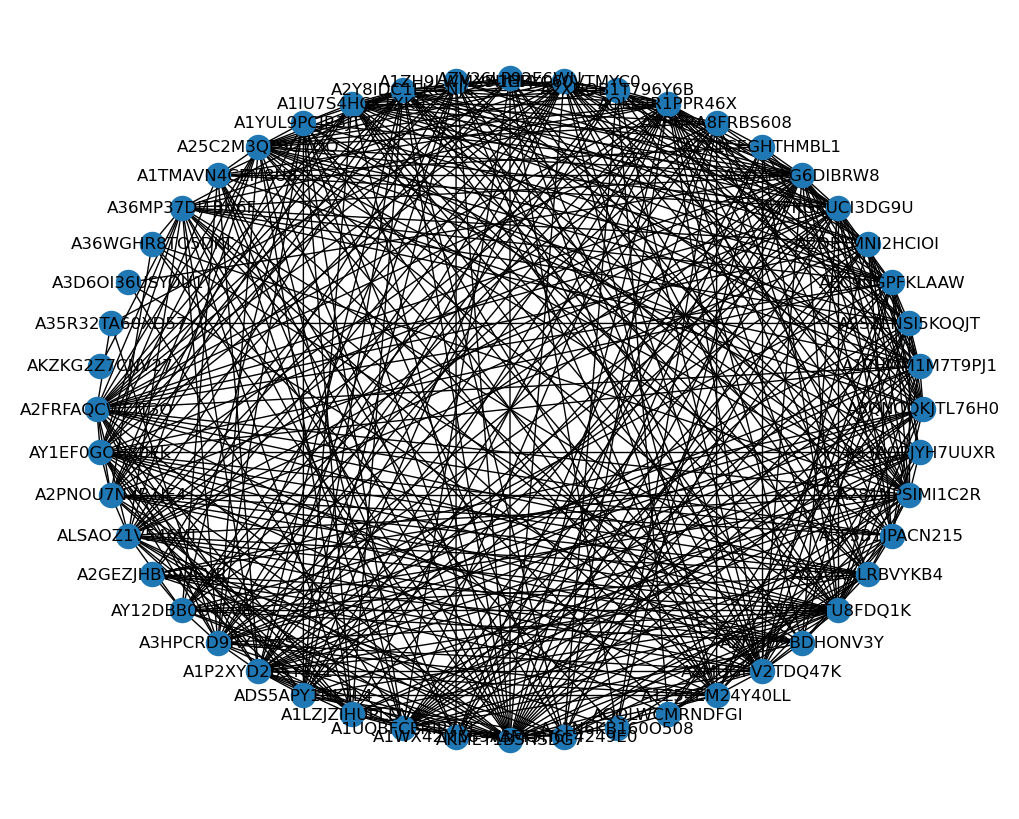

In [40]:
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [41]:
from pyvis.network import Network

food_plot = nx.from_pandas_edgelist(network, source='User A', target='User B')

node_degree = dict(food_plot.degree)
nx.set_node_attributes(food_plot, node_degree, 'size')

nt = Network(notebook=True, cdn_resources='remote', bgcolor="#222222", font_color="white")

nt.repulsion()

nt.from_nx(food_plot)
nt.show('food_plot.html')

food_plot.html


# Community Discovery

In [42]:
# community discovery using Louvain algorithm
communities = nx.community.louvain_communities(G, weight='Weight', seed=111)

In [43]:
print(f"Number of communities (according to greedy modularity algo): {len(communities)}")

Number of communities (according to greedy modularity algo): 6


# Community Visualization

In [44]:
communities_dict = {}

for i in range(len(communities)):
    for node in list(communities[i]):
        communities_dict[node] = i

nx.set_node_attributes(food_plot, communities_dict, name='group')

In [45]:
nt = Network(notebook=True, cdn_resources='remote', bgcolor="#222222", font_color="white")
nt.repulsion()

nt.from_nx(food_plot)
nt.show('food_communities.html')

food_communities.html


# Communities Analysis

In [74]:
# Create a function to get all combinations of pairs in a community
# And return a dataframe with all similar reviews between the pairs
def similar_reviews(users):
    user_a = users.copy()
    user_b = users.copy()
    
    # find the unique pairs between the users in this community
    unique_pairs = set()
    
    for x,y in product(user_a, user_b):
        if x != y:
            unique_pairs.add(tuple(sorted((x,y))))
            
    reviews = []

    for pair in unique_pairs:

        # Get the dataframe of reviews for each user
        user_a = df[df['UserId'] == pair[0]]
        user_b = df[df['UserId'] == pair[1]]

        # Find the intersection of reviews based on ProductId and Score
        same = pd.merge(user_a, user_b, on=['ProductId', 'Score'], how='inner')

        reviews.append(same)
        
    reviews_df = pd.concat(reviews)
    
    return reviews_df

In [75]:
# Store the list of users for each community into a nested list
coms = []

for community in communities:
    coms.append(list(community))

In [76]:
# Find the similar_reviews for each community of users
review_dfs = []

for community in coms:
    rdf = similar_reviews(community)
    review_dfs.append(rdf)

In [77]:
# Store the dataframes for each community into a variable
c0 = review_dfs[0]
c1 = review_dfs[1]
c2 = review_dfs[2]
c3 = review_dfs[3]
c4 = review_dfs[4]
c5 = review_dfs[5]

In [79]:
# Set the community for each dataframe
c0['Community'] = 0
c1['Community'] = 1
c2['Community'] = 2
c3['Community'] = 3
c4['Community'] = 4
c5['Community'] = 5

In [83]:
# Concat the dataframe into a single dataframe
coms_dfs = [c0, c1, c2, c3, c4, c5]
coms_df = pd.concat(coms_dfs)
coms_df

,ProductId,UserId_x,ProfileName_x,Helpfulness_x,Score,Time_x,Summary_x,Text_x,UserId_y,ProfileName_y,Helpfulness_y,Time_y,Summary_y,Text_y,Community
0,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0/0,5.0,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",ADS5APY1NKTL4,"D. Pawl ""Dani""",7/9,1175040000,great (hot) new flavor....,I am a great fan of potato chips and of Thai f...,0
1,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0/0,5.0,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",ADS5APY1NKTL4,"D. Pawl ""Dani""",5/7,1175040000,these potato chips are yummy....,"I try to be good, but when I feel like indulgi...",0
2,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0/0,5.0,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...,ADS5APY1NKTL4,"D. Pawl ""Dani""",7/9,1175040000,great (hot) new flavor....,I am a great fan of potato chips and of Thai f...,0
3,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0/0,5.0,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...,ADS5APY1NKTL4,"D. Pawl ""Dani""",5/7,1175040000,these potato chips are yummy....,"I try to be good, but when I feel like indulgi...",0
4,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2/2,5.0,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",ADS5APY1NKTL4,"D. Pawl ""Dani""",7/9,1175040000,great (hot) new flavor....,I am a great fan of potato chips and of Thai f...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,B004FGWU9O,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",0/0,4.0,1282176000,Medium Roast. Touch of Sweetness. Not Acidic. ...,Nice medium coffee blend that has a hint of va...,AQQLWCMRNDFGI,Steven A. Peterson,1/1,1322870400,Successful experiment!,Our Keurig coffee maker was a great Christmas ...,5
32,B003VXHGDM,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",19/20,4.0,1281916800,"Bold, but Not Teeth Jarring Bold. Nice Flavor ...","Wolfgang Puck French Roast is a nice, bold (no...",AQQLWCMRNDFGI,Steven A. Peterson,0/0,1304294400,Above average K-cup coffee,We have a Keurig coffee maker. One of the side...,5
33,B003VXHGDM,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",19/20,4.0,1281916800,"Bold, but Not Teeth Jarring Bold. Nice Flavor ...","Wolfgang Puck French Roast is a nice, bold (no...",AQQLWCMRNDFGI,Steven A. Peterson,1/1,1322870400,Successful experiment!,Our Keurig coffee maker was a great Christmas ...,5
34,B003VXHGDM,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",0/0,4.0,1282176000,Medium Roast. Touch of Sweetness. Not Acidic. ...,Nice medium coffee blend that has a hint of va...,AQQLWCMRNDFGI,Steven A. Peterson,0/0,1304294400,Above average K-cup coffee,We have a Keurig coffee maker. One of the side...,5


In [84]:
coms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 35
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductId      2017 non-null   object 
 1   UserId_x       2017 non-null   object 
 2   ProfileName_x  2017 non-null   object 
 3   Helpfulness_x  2017 non-null   object 
 4   Score          2017 non-null   float64
 5   Time_x         2017 non-null   object 
 6   Summary_x      2017 non-null   object 
 7   Text_x         2017 non-null   object 
 8   UserId_y       2017 non-null   object 
 9   ProfileName_y  2017 non-null   object 
 10  Helpfulness_y  2017 non-null   object 
 11  Time_y         2017 non-null   object 
 12  Summary_y      2017 non-null   object 
 13  Text_y         2017 non-null   object 
 14  Community      2017 non-null   int64  
dtypes: float64(1), int64(1), object(13)
memory usage: 252.1+ KB


In [85]:
# Get the average score for each community
gpby_com = coms_df.groupby('Community')['Score'].mean()
gpby_com

Community
0    5.000000
1    4.614035
2    4.554723
3    4.829352
4    5.000000
5    4.148148
Name: Score, dtype: float64

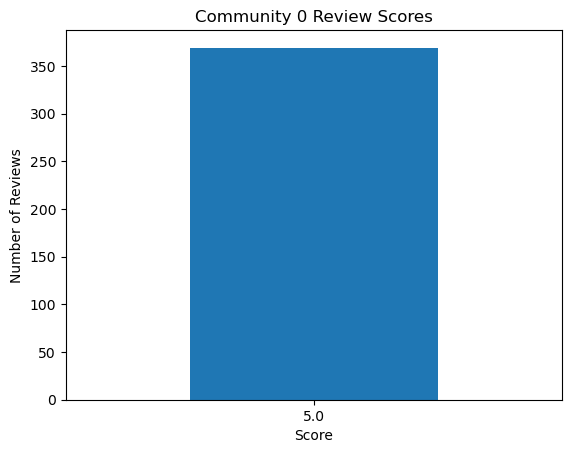

In [206]:
# Plot the Scores for community 0
c0['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 0 Review Scores");

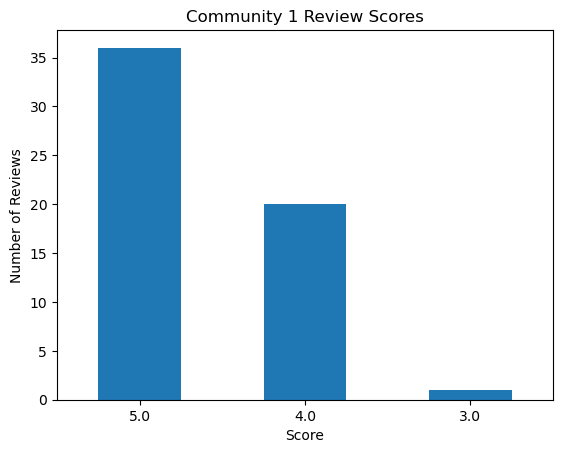

In [207]:
# Plot the Scores for community 1
c1['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 1 Review Scores");

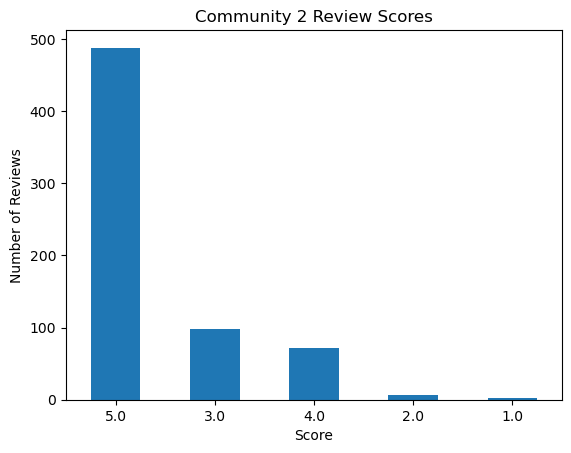

In [208]:
# Plot the Scores for community 2
c2['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 2 Review Scores");

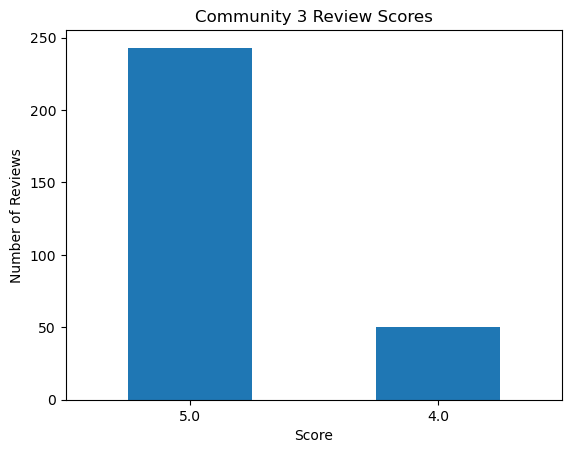

In [209]:
# Plot the Scores for community 3
c3['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 3 Review Scores");

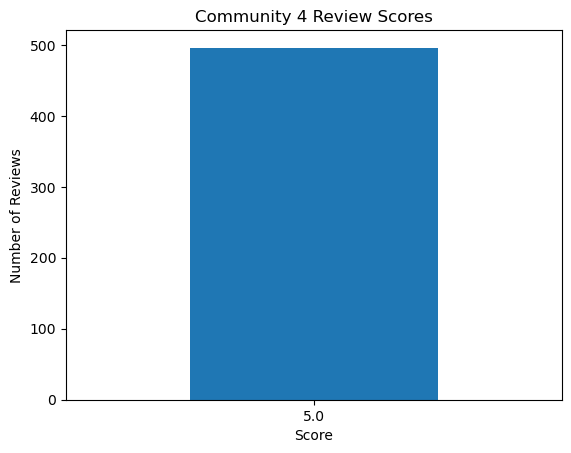

In [210]:
# Plot the Scores for community 4
c4['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 4 Review Scores");

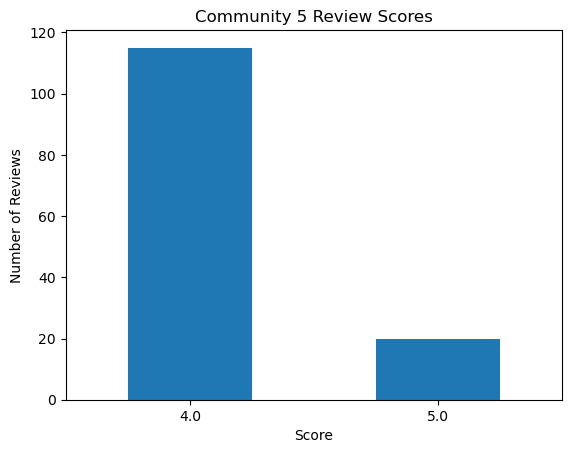

In [211]:
# Plot the Scores for community 5
c5['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.title("Community 5 Review Scores");

# Community Review Text Analysis

In [122]:
from string import punctuation
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

In [123]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syou1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [124]:
# Get stopwords
stop_words = (stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [120]:
# Create function to clean text
def clean_text(text):
    # Split the text based on spaces
    tokens = text.split()
    
    # Create a mapping function that maps all punctuation to nothing
    table = str.maketrans('', '', punctuation)
    
    # For each word in tokens, you put the translated word back into the list of tokens
    tokens = [word.translate(table) for word in tokens]
    
    # Remove anything non-alphabetic --> If the word is made up of letters, add it to the list
    tokens = [word for word in tokens if word.isalpha()]
    
    # Transform the words such that all the letters are lower case
    tokens = [word.lower() for word in tokens]
    
    # Drop all words that are in the stopwords list --> if word is not in stop_words list, then you drop it
    tokens = [word for word in tokens if not word in stop_words]
    
    # If the word is very short, then drop it
    tokens = [word for word in tokens if len(word) > 1]
    
    # Return the list of tokens as a string joined by spaces
    return ' '.join(tokens)

# Word Cloud Function

In [212]:
# Create a funciton to output a wordcloud with the top 50 keywords given a community of reviews

def generate_cloud(community_df, col1, col2):
    
    # Select the summaries 
    summaries = community_df[[col1, col2]]

    # Clean the text for each food review
    summaries[col1] = summaries[col1].apply(clean_text)
    summaries[col2] = summaries[col2].apply(clean_text)
    
    # Get the unique summaries
    uniq_s = list(summaries[col1].unique()) + list(summaries[col2].unique())
    
    # Create Tokenizer and fit on text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(uniq_s)
    
    # Get column names
    col_names = list(tokenizer.word_index)
    
    # Create Word Bag
    word_bag = tokenizer.texts_to_matrix(uniq_s, mode='binary')
    word_bag_df = pd.DataFrame(word_bag)
    word_bag_df.columns = ["dummy"] + col_names

    # Take the top 50 keywords
    keywords = pd.DataFrame(word_bag_df.sum().sort_values(ascending=False).head(100))
    keywords_dict = keywords.to_dict()[0]
    cloud_of_words = WordCloud(background_color='white').generate_from_frequencies(keywords_dict)
    plt.imshow(cloud_of_words, interpolation='bilinear')
    plt.axis('off');

In [213]:
import warnings
warnings.filterwarnings('ignore')

# C0 Word Clouds

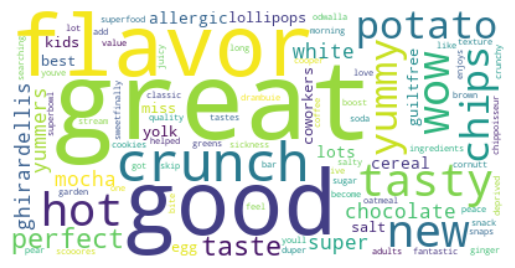

In [214]:
# Generate word cloud for c0 summaries
generate_cloud(c0, 'Summary_x', 'Summary_y')

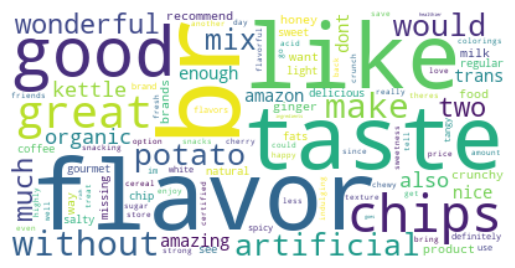

In [215]:
# Generate word cloud for c0 text
generate_cloud(c0, 'Text_x', 'Text_y')

# C1 Word Clouds

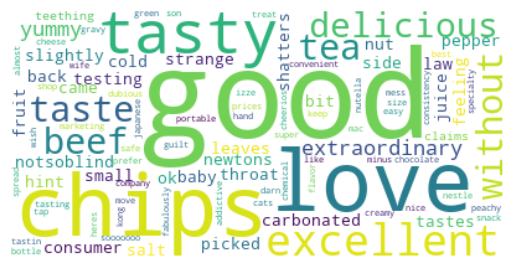

In [216]:
# Generate word cloud for c1 summaries
generate_cloud(c1, 'Summary_x', 'Summary_y')

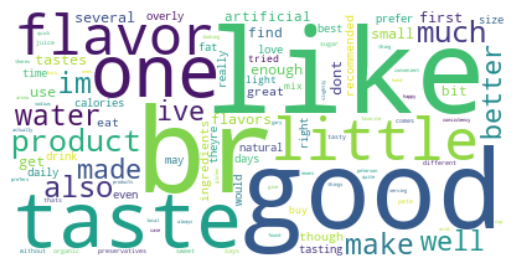

In [217]:
# Generate word cloud for c1 text
generate_cloud(c1, 'Text_x', 'Text_y')

# C2 Word Clouds

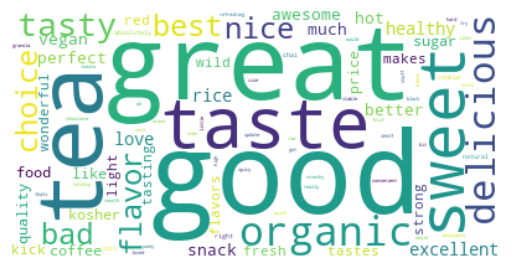

In [218]:
# Generate word cloud for c2 summaries
generate_cloud(c2, 'Summary_x', 'Summary_y')

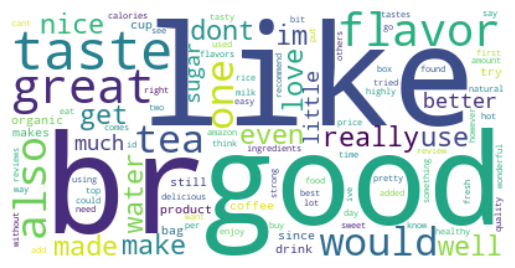

In [219]:
# Generate word cloud for c2 text
generate_cloud(c2, 'Text_x', 'Text_y')

# C3 Word Clouds

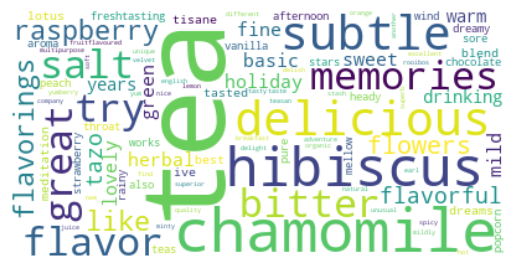

In [220]:
# Generate word cloud for c3 summaries
generate_cloud(c3, 'Summary_x', 'Summary_y')

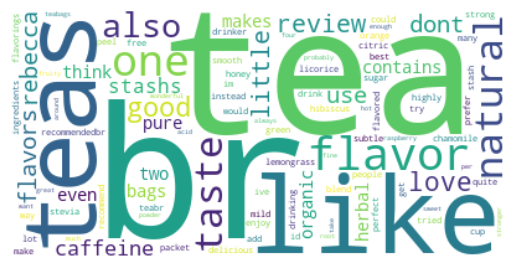

In [221]:
# Generate word cloud for c3 text
generate_cloud(c3, 'Text_x', 'Text_y')

# C4 Word Clouds

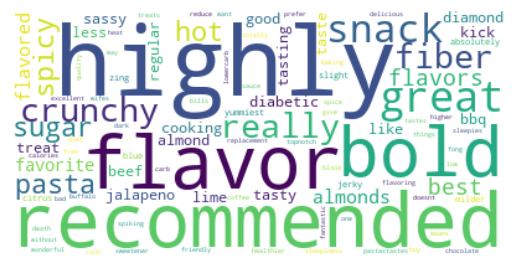

In [222]:
# Generate word cloud for c4 summaries
generate_cloud(c4, 'Summary_x', 'Summary_y')

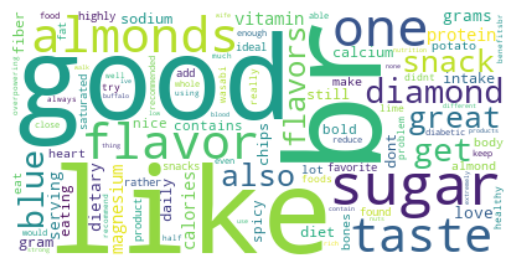

In [223]:
# Generate word cloud for c4 text
generate_cloud(c4, 'Text_x', 'Text_y')

# C5 Word Clouds

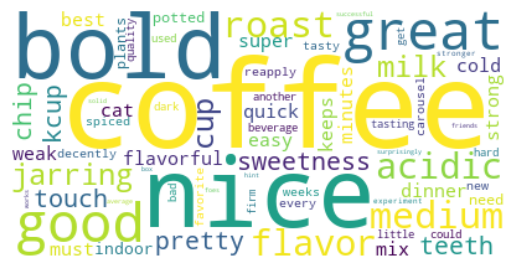

In [224]:
# Generate word cloud for c5 summaries
generate_cloud(c5, 'Summary_x', 'Summary_y')

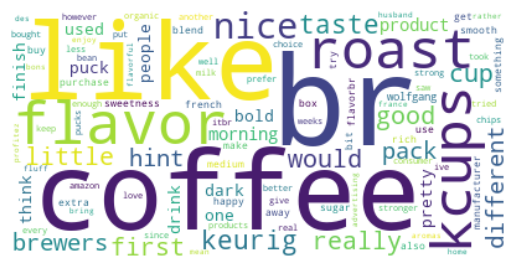

In [225]:
# Generate word cloud for c5 text
generate_cloud(c5, 'Text_x', 'Text_y')